<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Mar 17 01:52:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!pip install -q git+git://github.com/fastai/fastcore.git
!pip install -q git+git://github.com/fastai/fastai2.git
!pip install -q git+git://github.com/lgvaz/faststyle.git

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')
save_dir = root_dir/'dl/faststyle'; save_dir.mkdir(exist_ok=True, parents=True)
# save_dir = Path('.')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
source = untar_data(URLs.COCO_SAMPLE)

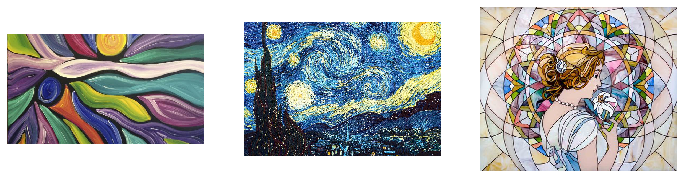

In [0]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L('village.png')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [0]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(512)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

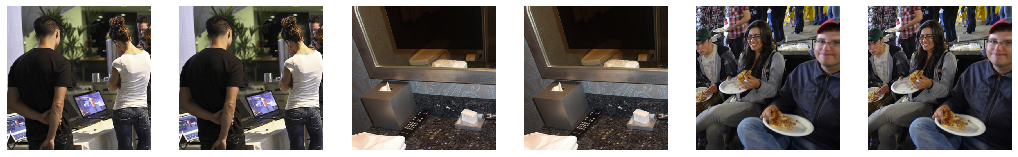

In [0]:
dls = dblock.dataloaders(source, bs=8)
dls.show_batch(rows=1, max_n=3)

In [0]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [0]:
m = TransformerNet()
cbs = [SaveModelCallback()]
loss_func = FastStyleLoss(stl_w=5e5, tv_w=1000)
learn = style_learner(dls, m, get_feats, style_fns, loss_func=loss_func, cbs=cbs)

In [0]:
learn.path = save_dir

In [0]:
# learn.lr_find()

In [0]:
!ls models

stage1.pth  stage2.pth	tn-abstract-starry-mosaic.pth


In [0]:
learn.fit_one_cycle(2, 1e-3, pct_start=.72)

epoch,train_loss,valid_loss,stl,cnt,tv,time


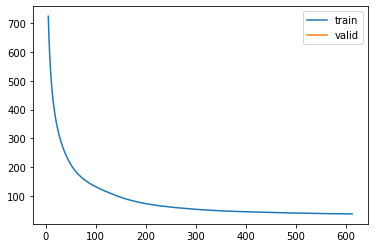

In [0]:
learn.recorder.plot_loss()

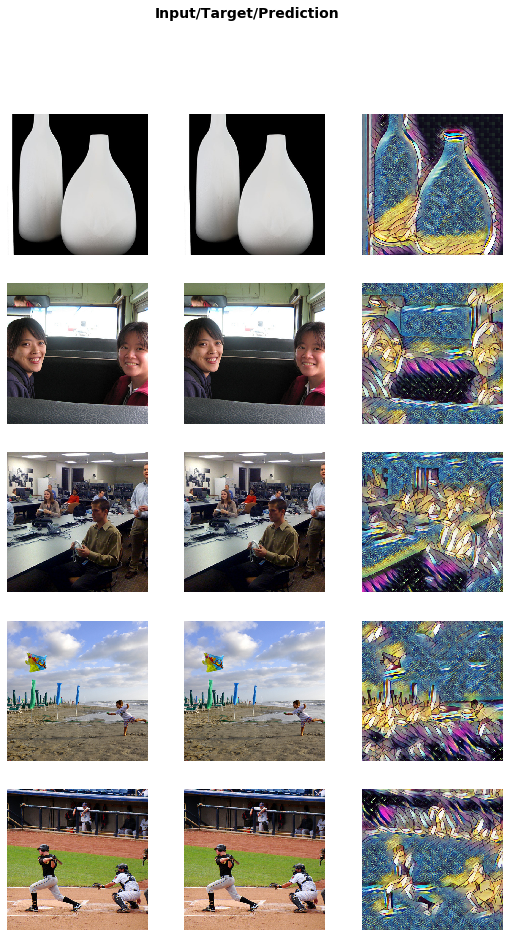

In [0]:
learn.show_results()

In [0]:
learn.save('tn-abstract-starry-mosaic-512')